In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from IPython import display
import time
import glob

from math import *
import random

def tovar(x):
    return torch.FloatTensor(x).cuda()

In [2]:
#! wget https://github.com/thorsilver/TripletCAEmbedding/raw/master/Results_CellPyLib_Random/triplet_CellLib_random.pth

In [3]:
class Triplet(nn.Module):
    def __init__(self):
        super(Triplet,self).__init__()
        
        self.l1a = nn.Conv3d(3,32,5,padding=2)
        nn.init.orthogonal_(self.l1a.weight, gain=sqrt(2))
        self.b1a = nn.BatchNorm3d(32)
        self.l1b = nn.Conv3d(32,32,5,padding=2)
        self.b1b = nn.BatchNorm3d(32)
        nn.init.orthogonal_(self.l1b.weight, gain=sqrt(2))
        self.p1 = nn.MaxPool3d(2)
        
        self.l2a = nn.Conv3d(32,64,5,padding=2)
        self.b2a = nn.BatchNorm3d(64)
        nn.init.orthogonal_(self.l2a.weight, gain=sqrt(2))
        self.l2b = nn.Conv3d(64,64,5,padding=2)
        self.b2b = nn.BatchNorm3d(64)
        nn.init.orthogonal_(self.l2b.weight, gain=sqrt(2))
        self.p2 = nn.MaxPool3d(2)

        self.l3a = nn.Conv3d(64,128,5,padding=2)
        self.b3a = nn.BatchNorm3d(128)
        nn.init.orthogonal_(self.l3a.weight, gain=sqrt(2))
        self.l3b = nn.Conv3d(128,128,5,padding=2)
        self.b3b = nn.BatchNorm3d(128)
        nn.init.orthogonal_(self.l3b.weight, gain=sqrt(2))
        self.p3 = nn.MaxPool3d(2)
        
        self.l4a = nn.Conv3d(128,256,5,padding=2)
        self.b4a = nn.BatchNorm3d(256)
        nn.init.orthogonal_(self.l4a.weight, gain=sqrt(2))
        self.l4b = nn.Conv3d(256,256,5,padding=2)
        self.b4b = nn.BatchNorm3d(256)
        nn.init.orthogonal_(self.l4b.weight, gain=sqrt(2))
        self.p4 = nn.MaxPool3d(2)
        
        self.l5 = nn.Linear(256,16,1)
        nn.init.orthogonal_(self.l5.weight, gain=sqrt(2))
        
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self, x):
        z = x
        z = F.leaky_relu(self.l1a(z))
        z = self.b1a(z)
        z = F.leaky_relu(self.l1b(z))
        z = self.b1b(z)
        z = self.p1(z)
        
        z = F.leaky_relu(self.l2a(z))
        z = self.b2a(z)
        z = F.leaky_relu(self.l2b(z))
        z = self.b2b(z)
        z = self.p2(z)
        
        z = F.leaky_relu(self.l3a(z))
        z = self.b3a(z)
        z = F.leaky_relu(self.l3b(z))
        z = self.b3b(z)
        z = self.p3(z)
        
        z = F.leaky_relu(self.l4a(z))
        z = self.b4a(z)
        z = F.leaky_relu(self.l4b(z))
        z = self.b4b(z)
        z = self.p4(z).mean(4).mean(3).mean(2)
        
        z = self.l5(z)
        z = z/torch.sqrt(torch.sum(z**2,1)+1e-4).unsqueeze(1)
        
        return z

In [4]:
def imload(fname):
    im = Image.open(fname)
    im = (np.array(im)-128.0)/128.0
    return im

def loadstack(name_root, maxt=32):
    stack = []
    
    for i in range(0,maxt,2):
        stack.append(imload(name_root+"_%.6d.png" % i))
    
    return np.array(stack).transpose(3,1,2,0) # ZR x XR x YR x 3 -> 3 x XR x YR x ZR

def imloadX(fname, x, y):
    im = Image.open(fname)
    im = (np.array(im)-128.0)/128.0
    x0 = x
    y0 = y
    return im[x0:x0+128,y0:y0+128,:]

def getSequence(carule, N=32):
    x1 = []
    
    for init in range(2):
        stack = loadstack("data2_2d/%.6d/%.6d" % (carule, init), maxt=1024)
        subx1 = []
        
        for i in range(N):
            t = int((1024-32)*(i/(N-1)))
            subx1.append(stack[:,:,:,t:t+32])
        x1.append(np.array(subx1))
        
    return np.array(x1) # init x frames x ...

sources = [ "/sata/data/ca/totalistic/%.6d" % c1 for c1 in range(1000) ] + \
          [ "/sata/data/ca/4neighbor/%.6d" % c1 for c1 in range(1000) ] + \
          [ "/sata/data/ca/8neighbor/%.6d" % c1 for c1 in range(3000) ] + \
          [ "/sata/data/ca/refined/%.6d" % c1 for c1 in range(3000)] + \
          [ "/sata/data/ca/refined2/%.6d" % c1 for c1 in range(3000)]

def getBatch(N=20):
    x1 = []
    x2 = []
    x3 = []
    
    for i in range(N):
        c1 = sources[np.random.randint(len(sources))]
        c2 = sources[np.random.randint(len(sources))]
        
        k1 = np.random.randint(20)
        k2 = np.random.randint(20)
        k3 = np.random.randint(20)
        
        x1.append(loadstack("%s/%.6d" % (c1,k1)))
        x2.append(loadstack("%s/%.6d" % (c1,k2)))
        x3.append(loadstack("%s/%.6d" % (c2,k3)))
    
    x1 = np.array(x1)
    x2 = np.array(x2)
    x3 = np.array(x3)
    
    return x1,x2,x3

In [5]:
net = Triplet().cuda()
net.load_state_dict(torch.load("triplet_ca_2d_multitype2.pth"))


<All keys matched successfully>

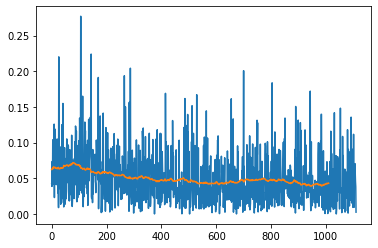

KeyboardInterrupt: 

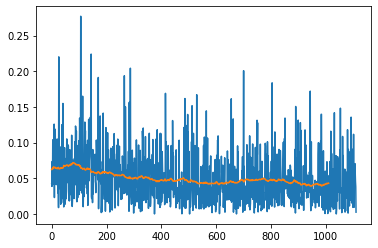

In [14]:
#tr_err = []
lossfn = nn.TripletMarginLoss(margin=1)

for p in net.optim.param_groups:
    p['lr'] = 1e-5

for epoch in range(10000):
    net.optim.zero_grad()
    
    net.train()
    err = []
    for i in range(10):
        x1,x2,x3 = getBatch(N=5)
        x1 = tovar(x1)
        x2 = tovar(x2)
        x3 = tovar(x3)

        y1 = net.forward(x1)
        y2 = net.forward(x2)
        y3 = net.forward(x3)

        loss = lossfn(y1,y2,y3)# + 1e-2 * ( torch.mean(y1**2) + torch.mean(y2**2) + torch.mean(y3**2))
        loss.backward()
        err.append(loss.cpu().detach().item())
    net.optim.step()
    
    tr_err.append(np.mean(err))
    plt.clf()
    cs = np.cumsum(tr_err)
    cs = (cs[100:] - cs[:-100])/100.0
    plt.plot(tr_err)
    plt.plot(cs)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

In [32]:
torch.save(net.state_dict(), open("triplet_ca_2d_multitype2.pth","wb"))

In [6]:
net.eval()

ims = []
ims2 = []
fnames = []
latents = []

for i in range(len(sources)//20):
    if i%10 == 0:
        print(i)
    x1 = []
    
    for j in range(20):
        c1 = sources[j + 20*i]
        
        k1 = 0
        
        fnames.append("%s/%.6d" % (c1,k1))
        x1.append(loadstack("%s/%.6d" % (c1,k1)))
    x1 = np.array(x1)
    
    with torch.no_grad():
        z1 = net.forward(tovar(x1)).cpu().detach().numpy()
    
    for i in range(x1.shape[0]):
        ims.append(np.clip(0.5+0.5*x1[i,:,:,:,14].transpose(1,2,0),0,1))
        ims2.append(np.clip(0.5+0.5*x1[i,:,:,:,15].transpose(1,2,0),0,1))
        latents.append(z1[i])
ims = np.array(ims)
ims2 = np.array(ims2)
latents = np.array(latents)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540


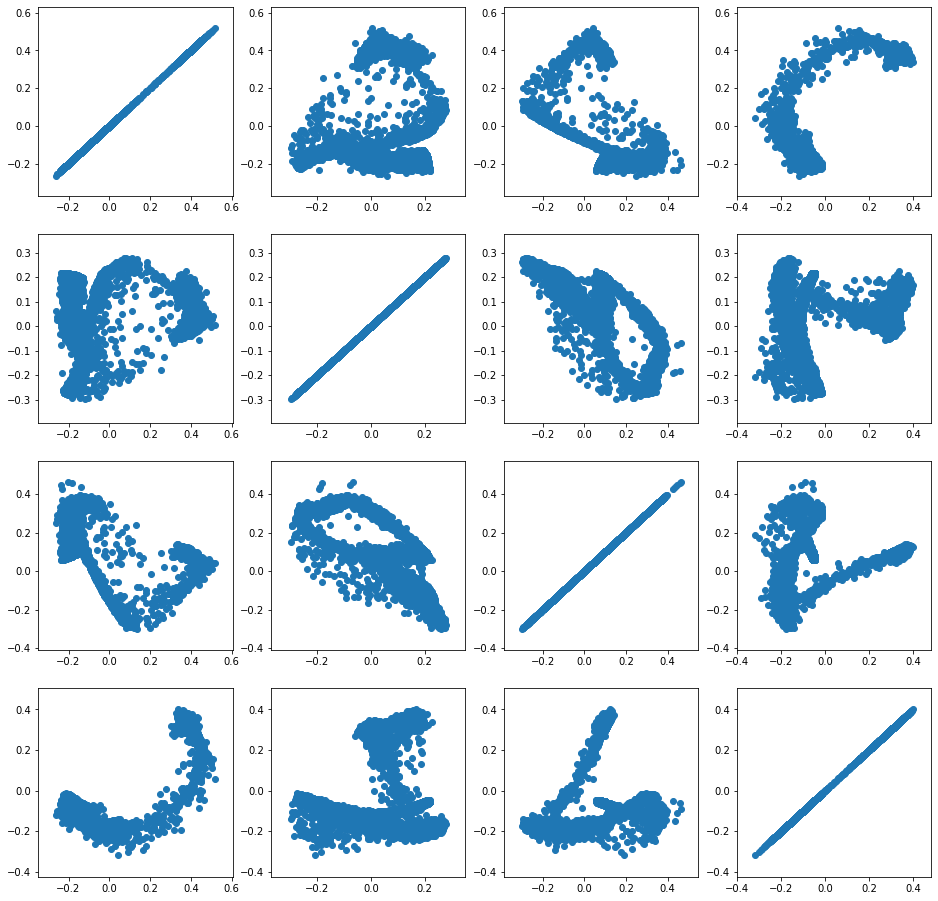

In [11]:
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,1+i+4*j)
        plt.scatter(latents[:,i], latents[:,j])

plt.gcf().set_size_inches((16,16))
plt.show()

In [22]:
import umap
import pickle
clf = umap.UMAP(n_components=2, n_neighbors=30, min_dist = 0.25)

ulatents = clf.fit_transform(latents)

#clf = pickle.load(open("umap_classifier_multi.pkl", "rb"))
#ulatents = clf.transform(latents)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [23]:
ulatents.shape[0]

11000

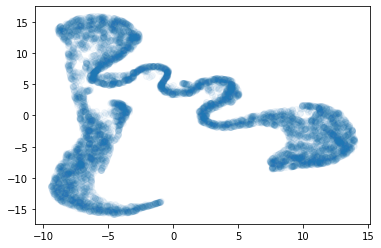

In [24]:
plt.scatter(ulatents[:,0], ulatents[:,1], alpha=0.04)
plt.show()

In [25]:
def canonicalize(im):
    iim = (256*im[:,:,0]).astype(np.int32) + 256*(256*im[:,:,1]).astype(np.int32) + 256*256*(256*im[:,:,2]).astype(np.int32)
    colors = np.unique(iim)
    counts = np.array([ np.sum(iim == colors[i]) for i in range(colors.shape[0])])
    reidx = np.argsort(-counts)
    colors = colors[reidx]
    
    idx = np.zeros((iim.shape[0], iim.shape[1]))
    for i in range(colors.shape[0]):
        match = 1.0*(iim==colors[i])
        idx = idx*(1-match) + i*match
    idx = idx.astype(np.int32)
    
    rgbset = np.array([
        [0,0,0],
        [1,1,1],
        [1,0,0],
        [0,1,0],
        [0,0,1],
        [1,0,1],
        [0,1,1],
        [1,1,0]
    ])    
    
    newim = rgbset[idx]
    
    return newim

In [26]:
xmin = np.min(ulatents[:,0])-1
xmax = np.max(ulatents[:,0])+1
ymin = np.min(ulatents[:,1])-1
ymax = np.max(ulatents[:,1])+1

XR = 128
YR = 128
im = np.zeros((32*XR,32*YR,3))+0.5

f = open("ca_index_3.txt","w")

for x in range(XR):
    for y in range(YR):
        posx = xmin+(xmax-xmin)*(x+0.5)/XR
        posy = ymin+(ymax-ymin)*(y+0.5)/YR
        
        dist = (ulatents[:,0] - posx)**2 + (ulatents[:,1]-posy)**2
        nearest = np.argmin( dist )
        mindist = dist[nearest]
        
        if mindist<0.015:
            im[32*x:32*x+32,32*y:32*y+32,:] = canonicalize(ims2[nearest])[32:64,32:64,:]
            f.write("%d %d %s\n" % (x,y,fnames[nearest]))

f.close()
im = np.clip(256*im,0,255).astype(np.uint8)
im = Image.fromarray(im)
im.save("ca2d_embedding_multi_3.png")

In [29]:
ulatents.shape[0]

8000

In [30]:
import pickle

In [31]:
pickle.dump(clf, open("umap_classifier_multi_4.pkl","wb"))